# Data With Geometry

## Imports and configuration

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC, STATE_NAMES_FROM_IDS, STATE_GA

In [3]:
SHAPEFILE_ROOT = os.path.join(os.environ["HOME"], "data", "shapefiles")

# Make sure it is there.
if not os.path.isdir(SHAPEFILE_ROOT):
    os.mkdir(SHAPEFILE_ROOT)

## What dataset and variables?

In [4]:
DATASET = "acs/acs5"
YEAR = 2020

In [5]:
# This is a census variable for median household income.
# See https://api.census.gov/data/2020/acs/acs5/variables/B19013_001E.html
MEDIAN_HOUSHOLD_INCOME_VARIABLE = "B19013_001E"

In [6]:
VARIABLES = ['NAME', MEDIAN_HOUSHOLD_INCOME_VARIABLE]

In [7]:
MISSING_VALUE = -666666666

## Shapefile reader

In [8]:
reader = cem.ShapeReader(SHAPEFILE_ROOT, year=YEAR)
ced.set_shapefile_path(SHAPEFILE_ROOT)

In [9]:
gdf_state_bounds = reader.read_cb_shapefile("us", "state")
gdf_state_bounds = gdf_state_bounds[gdf_state_bounds["STATEFP"].isin(ALL_STATES_AND_DC)]

## Function to drop missing values

In [10]:
CENSUS_MISSING_VALUE = -666666666

def drop_missing_mhi(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    return gdf[gdf[MEDIAN_HOUSHOLD_INCOME_VARIABLE] != CENSUS_MISSING_VALUE]

## Plot function

In [11]:
plt.rcParams["figure.figsize"] = (18, 8)

def plot_map(
    gdf: gpd.GeoDataFrame,
    geo: str,
    *,
    gdf_bounds: Optional[gpd.GeoDataFrame] = None,
    bounds_color: str = "white",
    max_income: float = 200_000.0,
):
    if gdf_bounds is None:
        gdf_bounds = gdf

    ax = cem.plot_us(
        gdf_bounds,
        color="lightgray"
    )
    
    ax = cem.plot_us(
        gdf,
        MEDIAN_HOUSHOLD_INCOME_VARIABLE,
        cmap="autumn",
        legend=True,
        vmin=0.0,
        vmax=max_income,
        ax=ax,
    )

    ax = cem.plot_us_boundary(
        gdf_bounds, 
        edgecolor=bounds_color, 
        linewidth=0.5, 
        ax=ax
    )

    ax.set_title(f"{YEAR} Median Household Income by {geo.title()}")

    ax.axis("off")

## Query with geography

### Region

In [12]:
gdf_region = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    region="*",
    with_geometry=True
)

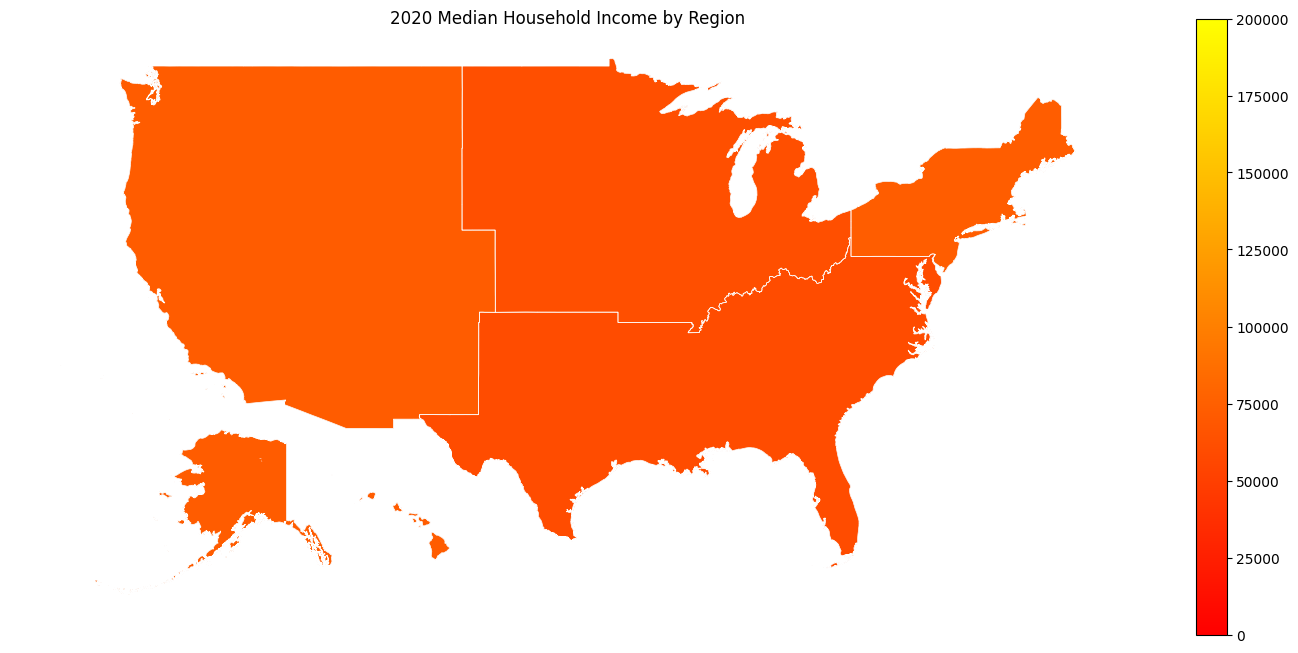

In [13]:
plot_map(gdf_region, "region")

### Division

In [14]:
gdf_division = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    division="*",
    with_geometry=True
)

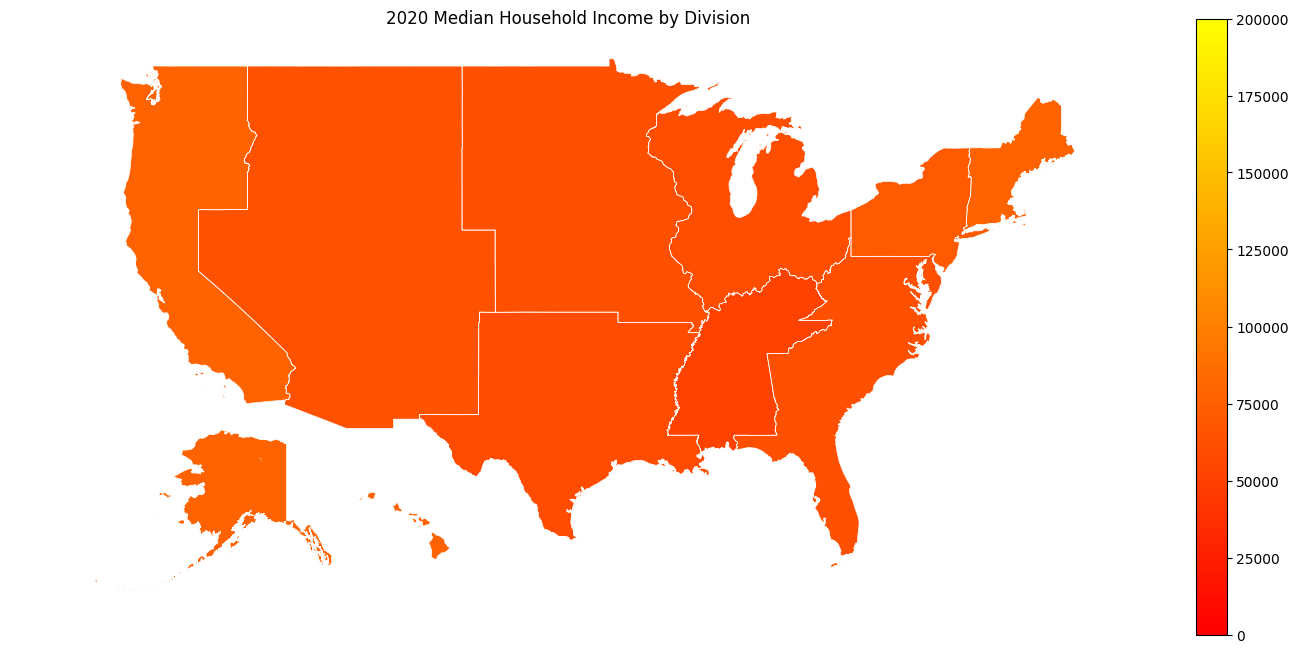

In [15]:
plot_map(gdf_division, "division")

### State

In [16]:
gdf_state = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    state="*",
    with_geometry=True
)

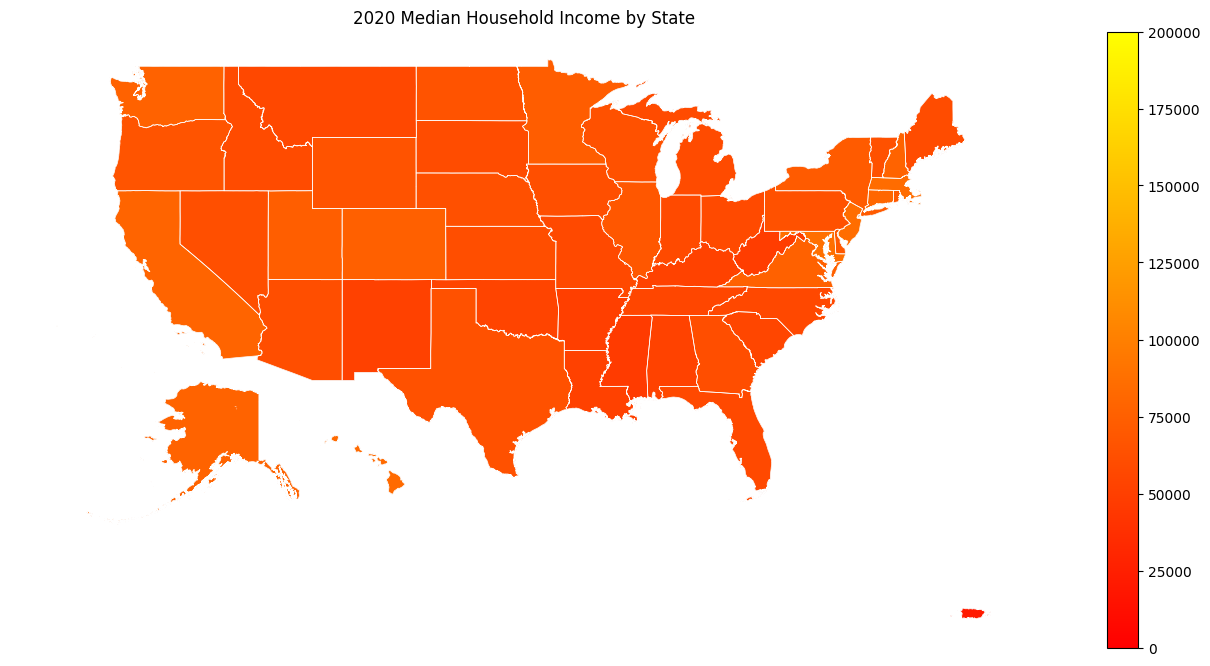

In [17]:
plot_map(gdf_state, "state")

### CBSA

In [18]:
gdf_cbsa = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    metropolitan_statistical_area_micropolitan_statistical_area="*",
    with_geometry=True
)

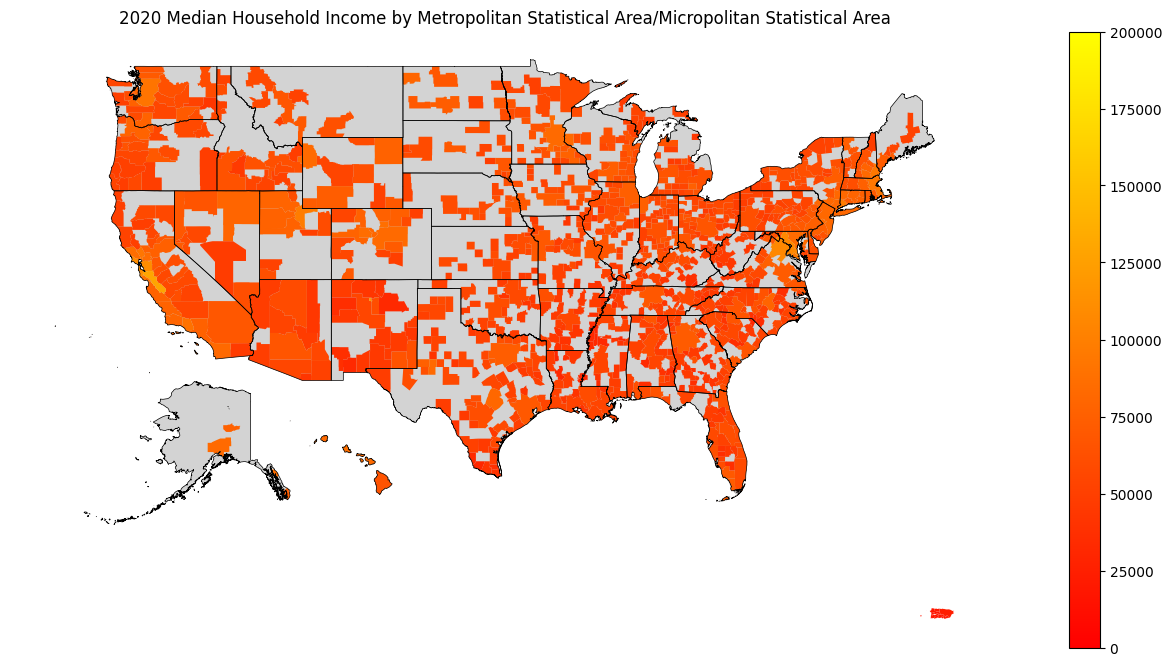

In [19]:
plot_map(
    gdf_cbsa, 
    "metropolitan statistical area/micropolitan statistical area",
    gdf_bounds=gdf_state_bounds, 
    bounds_color='black'
)

### CSA

In [20]:
gdf_csa = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    combined_statistical_area="*",
    with_geometry=True
)

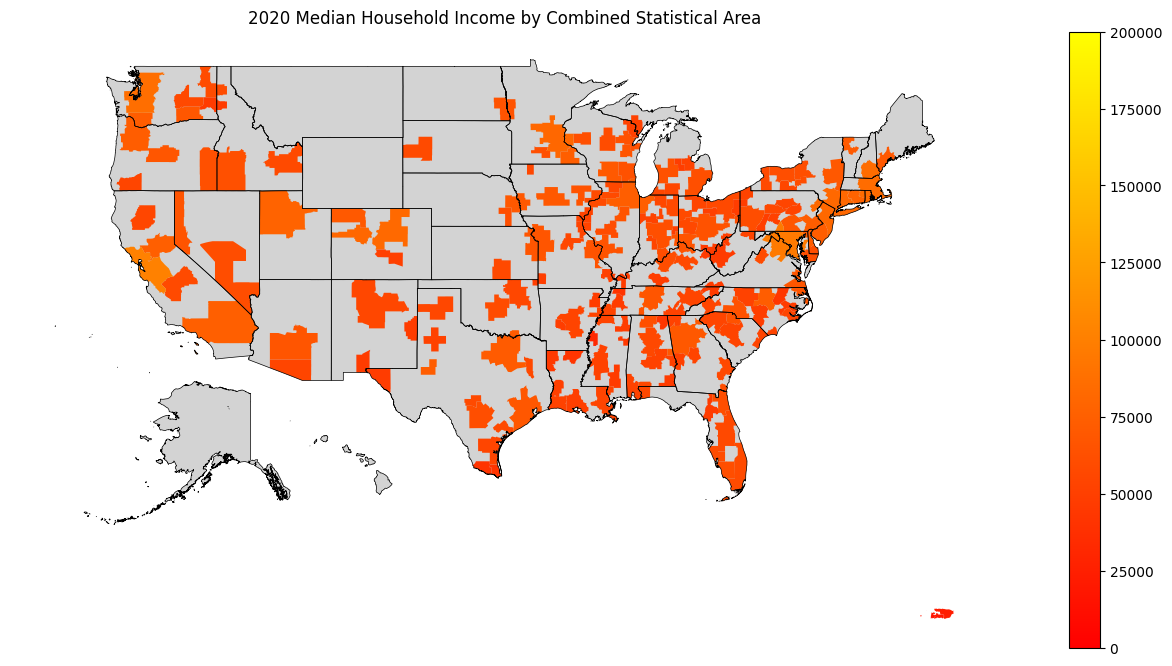

In [21]:
plot_map(
    gdf_csa, 
    "combined statistical area", 
    gdf_bounds=gdf_state_bounds, 
    bounds_color='black'
)

### County

In [22]:
gdf_county = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    state="*",
    county="*",
    with_geometry=True
)

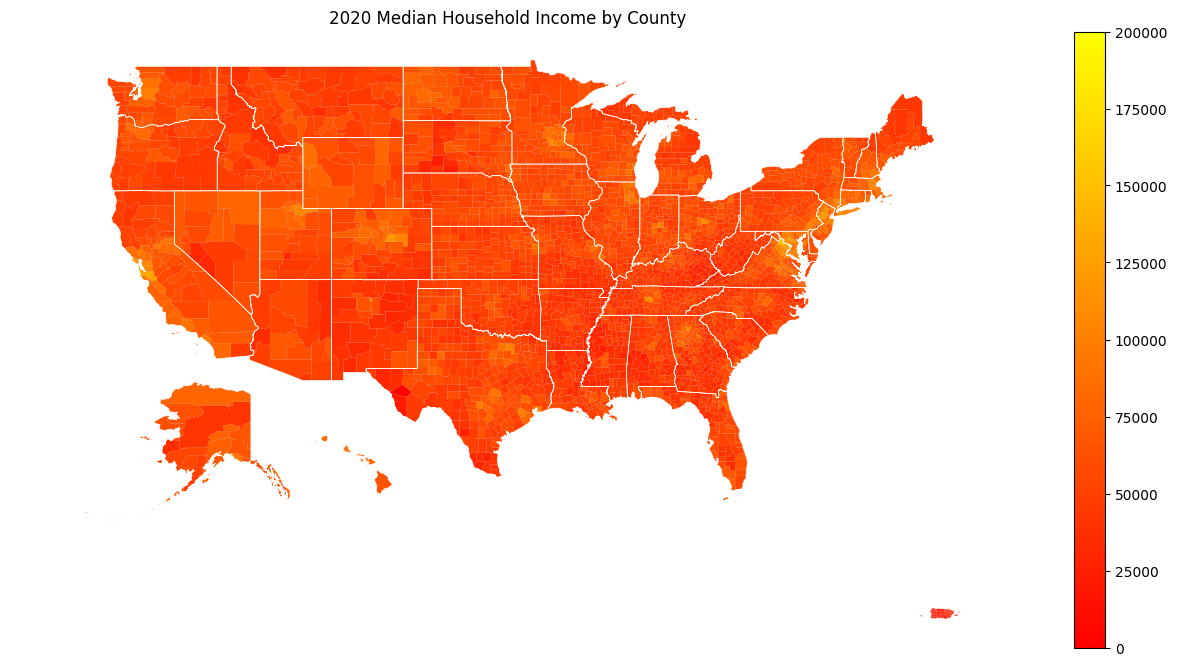

In [23]:
plot_map(gdf_county, "county", gdf_bounds=gdf_state_bounds)

### Census Tract

In [24]:
STATE = STATE_GA

In [25]:
gdf_tract = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE,
    tract="*",
    with_geometry=True
)

gdf_tract = drop_missing_mhi(gdf_tract)

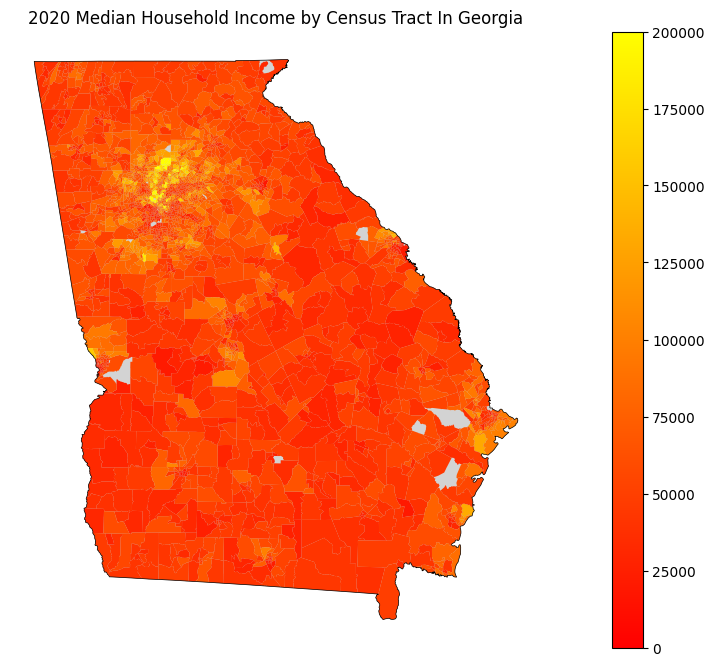

In [26]:
plot_map(
    gdf_tract, 
    f"census tract in {STATE_NAMES_FROM_IDS[STATE]}",     
    gdf_bounds=gdf_state_bounds[gdf_state_bounds['STATEFP']==STATE],
    bounds_color='black'
)

### Block Group

In [27]:
gdf_bg = ced.download_detail(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE,
    block_group="*",
    with_geometry=True
)

In [28]:
gdf_bg = drop_missing_mhi(gdf_bg)

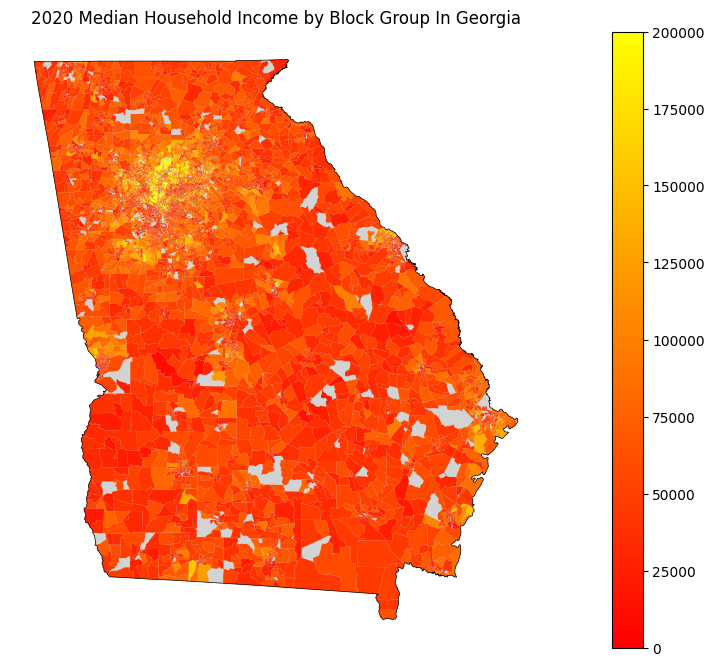

In [29]:
plot_map(
    gdf_bg, 
    f"block group in {STATE_NAMES_FROM_IDS[STATE]}", 
    gdf_bounds=gdf_state_bounds[gdf_state_bounds['STATEFP']==STATE],
    bounds_color='black'
)